In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from joblib import Parallel, delayed
import time

In [2]:
# predictions_rootdir = '/home/yuncong/csd395/CSHL_patch_predictions_svm_Sat16ClassFinetuned'
# predictions_rootdir = '/home/yuncong/csd395/CSHL_patch_predictions_svm_Sat16ClassFinetuned_v2/'
predictions_rootdir = create_if_not_exists('/home/yuncong/csd395/CSHL_patch_predictions_svm_Sat16ClassFinetuned_v3')

In [3]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

colors = np.random.randint(0, 255, (len(labels_index), 3))

In [7]:
stack = 'MD589'
# stack = 'MD594'
first_bs_sec, last_bs_sec = section_range_lookup[stack]
first_detection_sec, last_detection_sec = detect_bbox_range_lookup[stack]

In [ ]:
true_labels = np.load('/home/yuncong/csd395/CSHL_patch_features_Sat16ClassFinetuned/%(stack)s/%(sec)04d/%(stack)s_%(sec)04d_roi1_labels.npy' % \
                         {'stack':stack, 'sec': sec})

In [8]:
n_labels = len(labels_surroundIncluded_index)
M = np.zeros((n_labels, n_labels), np.int)
M_soft = np.zeros((n_labels, n_labels))

for sec in range(first_detection_sec, last_detection_sec+1):
    
    try:
        true_labels = np.load('/home/yuncong/csd395/CSHL_patch_features_Sat16ClassFinetuned/%(stack)s/%(sec)04d/%(stack)s_%(sec)04d_roi1_labels.npy' % \
                         {'stack':stack, 'sec': sec})
    except:
        continue
    
    print sec
    
    n = len(true_labels)
    
    scores = np.zeros((n, len(labels_surroundIncluded_index)))
    for l in labels_surroundIncluded_list:
        if not l.endswith('surround'):
            scores[:, labels_surroundIncluded_index[l]] = np.load(predictions_rootdir + '/%(stack)s/%(sec)04d/%(stack)s_%(sec)04d_roi1_%(label)s_sparseScores.npy' % \
                         {'stack':stack, 'sec': sec, 'label': l})
        else:
            scores[:, labels_surroundIncluded_index[l]] = 1 - scores[:, labels_surroundIncluded_index[labels_from_surround[l]]]
        
#     hard_predictions = np.argmax(predictions, axis=1)

#     for hp, tl in zip(hard_predictions, true_labels):
#         if tl == -1: continue
#         M[tl, hp] += 1
        
    for probs, tl in zip(scores, true_labels):
        if tl == -1: 
            continue
        M_soft[tl] += probs

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316


In [163]:
# n_labels = len(labels)
# M = np.zeros((n_labels, n_labels), np.int)
# for hp, tl in zip(hard_predictions, true_labels):
#     if tl == -1: continue
#     M[tl, hp] += 1
    
# M_soft = np.zeros((n_labels, n_labels))
# for probs, tl in zip(predictions, true_labels):
#     if tl == -1: continue
#     M_soft[tl] += probs

In [9]:
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(4,4), text=True, axis=None):
    
    if axis is None:
        fig = plt.figure(figsize=figsize)
        axis = fig.add_subplot(1,1,1)
    
    axis.imshow(cm, interpolation='nearest', cmap=cmap)
    axis.set_title(title)
#     plt.colorbar()
    axis.set_xticks(np.arange(len(labels)))
    axis.set_yticks(np.arange(len(labels)))
    axis.set_xticklabels(labels)
    axis.set_yticklabels(labels)
    
    axis.set_ylabel('True label')
    axis.set_xlabel('Predicted label')
    
    if cm.dtype.type is np.int_:
        fmt = '%d'
    else:
        fmt = '%.2f'
    
    if text:
        for x in xrange(len(labels)):
            for y in xrange(len(labels)):
                if not np.isnan(cm[y,x]):
                    axis.text(x,y, fmt % cm[y,x], 
                             horizontalalignment='center',
                             verticalalignment='center');

In [28]:
# plot_confusion_matrix(M, title='Confusion matrix for test brain MD594', labels=labels);

# cm_normalized = M.astype(np.float)/M.sum(axis=1)[:, np.newaxis]
# plot_confusion_matrix(cm_normalized, title='Confusion matrix for test brain MD594', labels=labels);

# cm_soft_normalized = M_soft.astype(np.float)/M_soft.sum(axis=1)[:, np.newaxis]
# plot_confusion_matrix(cm_soft_normalized, 
#                       title='soft Confusion matrix for test brain %s'%stack, 
#                       labels=labels_surroundIncluded_list,
#                      figsize=(20,20));

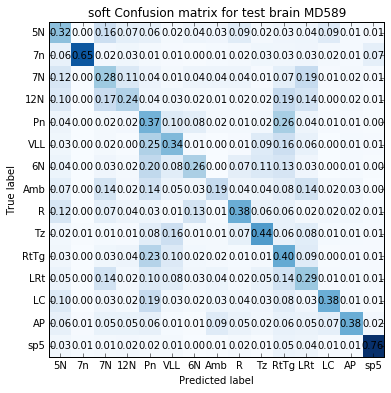

In [10]:
labs = labels_surroundIncluded_list[:n_labels/2]

cm_soft_normalized = M_soft[:n_labels/2, :n_labels/2].astype(np.float)/M_soft[:n_labels/2, :n_labels/2].sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_soft_normalized, 
                      title='soft Confusion matrix for test brain %s'%stack, 
                      labels=labs,
                     figsize=(6,6));

In [11]:
# show confusing pairs

confusing_pairs = []
for i, j in np.c_[np.where(cm_soft_normalized > .1)]:
    if (j, i) not in confusing_pairs and i != j:
        confusing_pairs.append((i,j))
        
for i, j in confusing_pairs:
    print labs[i], labs[j]

5N 7N
7N 12N
7N LRt
12N 5N
12N RtTg
12N LRt
Pn RtTg
VLL Pn
VLL RtTg
6N Pn
6N Tz
6N RtTg
Amb 7N
Amb Pn
Amb LRt
R 5N
R 6N
Tz VLL
LRt RtTg
LC 5N
LC Pn


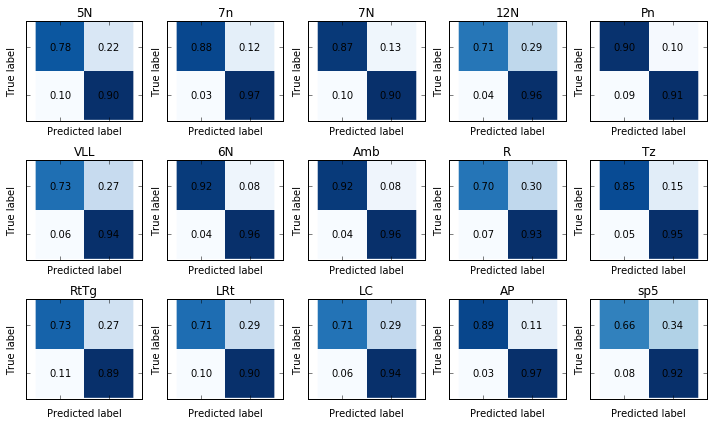

In [12]:
fig, axes = plt.subplots(3, 5, figsize=(5*2, 3*2), sharex=True, sharey=True)
axes = axes.flatten()

for l in labels[1:]:
    
    i1 = labels_surroundIncluded_index[l]
    i2 = labels_surroundIncluded_index[l + '_surround']
    
    M1 =  M_soft[np.array([i1,i2])[:,None], [i1,i2]].astype(np.float)
    
    cm_soft_normalized = M1/M1.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_soft_normalized, 
                          title='%(label)s'% {'label':l},
                          labels=['',''],
                         axis=axes[labels_index[l]-1]);

plt.tight_layout()